In [801]:
import casadi as ca
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.spatial import ConvexHull
from scipy.linalg import sqrtm, inv

In [802]:
nu = 2
N_Sam = 10

In [803]:
random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)

[[-0.3014934   0.7053482   0.8832414  -0.85042731  0.75647158  0.99253696
   0.64558604 -0.37129622 -0.98161309 -0.88509915]
 [ 0.45766614 -0.96400769  0.70205823 -0.68799117  0.5343924  -0.93562195
  -0.06566746 -0.87435909 -0.11859309 -0.46627848]]


In [804]:
data_id = "08"
background_filepath = f"./data/{data_id}_background.png"
recordingMeta_filepath = f"./data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./data/{data_id}_tracksMeta.csv"
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 14]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
random_vals = np.vstack((xAcc,yAcc))
N_Sam = random_vals.shape[1]

In [805]:
def opti_SDP_ca():   
    opti = ca.Opti()

    A = opti.variable(nu,nu)
    b = opti.variable(nu,1)

    samples = opti.parameter(nu,N_Sam)

    opti.minimize(ca.log(ca.det(ca.inv(A))))

    for i in range(N_Sam):
        opti.subject_to(ca.norm_2(A@samples[:,i]+b)**2<=1)

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f',[samples],[A,b])

In [806]:
def opti_SDP(nu,N_Sam,samples):
    A = cp.Variable((nu, nu), PSD=True)
    b = cp.Variable((nu, 1))
    constraints = [A - 1e-8*np.eye(nu) >> 0]
    for i in range(N_Sam):
        constraints += [cp.norm(A@cp.reshape(samples[:,i], (2, 1)) + b, 2) <= 1]
    objective = cp.Maximize(cp.log_det(A))

    problem = cp.Problem(objective, constraints)
    problem.solve(solver = cp.SCS) # verbose=True

    return A.value, b.value

In [807]:
A_hat, b_hat = opti_SDP(nu,N_Sam,random_vals)
print(A_hat)
print(b_hat)

/Users/qdzhou/CourseWork/FYP/fyp_env/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


[[ 0.30750622 -0.06206027]
 [-0.06206027  0.3714537 ]]
[[-0.56548722]
 [ 0.43012983]]


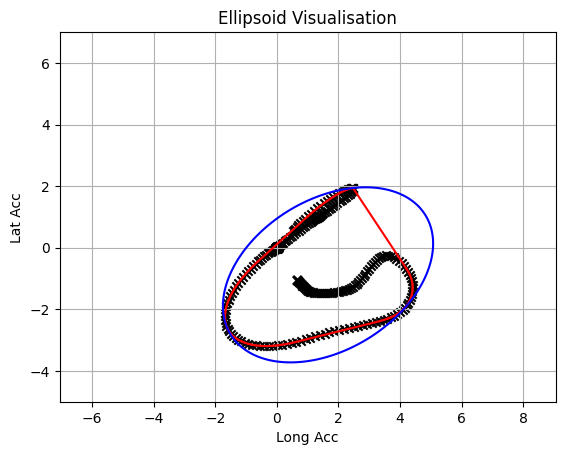

In [808]:
import numpy as np
import matplotlib.pyplot as plt

# Define the matrix A and vector b for the 2D ellipsoid
A = A_hat
b = b_hat

# Create a grid of points (u, v) in the plane
u_range = np.linspace(-5, 7, 400)
v_range = np.linspace(-5, 7, 400)
u, v = np.meshgrid(u_range, v_range)

# Vectorize u and v to apply the transformation
uv = np.vstack([u.flatten(), v.flatten()]).T

# Apply the transformation A*u + b
transformed_uv = np.dot(uv, A.T) + b.T

# Compute the quadratic form ||A*u + b||^2
quad_form = np.sum(transformed_uv**2, axis=1)

# Reshape to match the grid shape
quad_form = quad_form.reshape(u.shape)

points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

# Plot the 2D ellipsoid using contour plot
plt.contour(u, v, quad_form, levels=[1], colors='b')  # Level set at 1
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')
plt.title("Ellipsoid Visualisation")
plt.xlabel('Long Acc')
plt.ylabel('Lat Acc')
plt.axis('equal')
plt.grid(True)
plt.show()


In [809]:
def opti_SDP_lemma1(nu, sample, A_pre, b_pre):
    # Define variables
    B = cp.Variable((nu, nu), PSD=True)
    b_tilde = cp.Variable((nu, 1))
    tau1 = cp.Variable((1, 1))
    tau2 = cp.Variable((1, 1))
    tau = [tau1, tau2]

    # Parameters
    A = A_pre
    b = b_pre
    sample = cp.reshape(sample, (2, 1))

    # Define G, g, and c
    G1 = A.T @ A
    g1 = (A @ b).T
    c1 = b.T @ b - 1
    G2 = np.identity(2)
    g2 = -sample.T
    c2 = (sample.T @ sample) - 1e-8
    G = [G1, G2]
    g = [g1, g2]
    c = [c1, c2]

    # Constraints for tau
    constraints = [tau1 >= 0, tau2 >= 0]

    # Loop to create the block matrix constraints
    for i in range(2):
        tmp1 = cp.reshape(B - tau[i] * G[i], (2, 2), order='C')  # Specify order 'C' to suppress the warning
        tmp2 = cp.reshape(b_tilde - tau[i] * (g[i].T), (2, 1), order='C')
        tmp3 = cp.reshape(-1 - tau[i] - c[i], (1, 1), order='C')
        zeros = cp.Constant(np.zeros((2, 2)))  # Explicit constant for zeros

        # Construct the block matrix using cp.bmat
        tmp_matrix = cp.bmat([
            [tmp1, tmp2, zeros],
            [tmp2.T, tmp3, b_tilde.T],
            [zeros, b_tilde, -B],
        ])
        
        # Add the semidefinite constraint
        constraints += [tmp_matrix << 0]

    # Objective function
    objective = cp.Maximize(cp.log_det(B))

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)

    return B.value, b_tilde.value

In [810]:
def opti_SDP_lemma(nu, A_last, b_last, c_last, u_last): 
    B         = cp.Variable((nu, nu), PSD=True) # B = A**2
    tau       = cp.Variable( )
    tau_u     = cp.Variable( )
    b_tilde   = cp.Variable((nu, 1)) # b_tilde = A@b

    A_u = np.eye(nu)
    b_u = -u_last.reshape(2, 1)
    c_u = u_last.T@u_last - 1e-8

    zero_block = np.zeros((nu, nu))
    
    M  = cp.bmat([[B - tau * A_last, b_tilde - tau * b_last, zero_block],
                    [(b_tilde - tau * b_last).T, cp.reshape(-1 - tau * c_last, (1, 1)), b_tilde.T],
                    [zero_block, b_tilde, -B]])
    Mu = cp.bmat([[B - tau_u * A_u, b_tilde - tau_u * b_u, zero_block],
                    [(b_tilde - tau_u * b_u).T, cp.reshape(-1 - tau_u * c_u, (1, 1)), b_tilde.T],
                    [zero_block, b_tilde, -B]])
    
    constraints = [tau >= 0, tau_u >= 0, -M >> 0, -Mu >> 0, B - 1e-8*np.eye(nu) >> 0]  
    objective   = cp.Maximize(cp.log_det(B))
    problem     = cp.Problem(objective, constraints)
    problem.solve(solver = cp.MOSEK)

    return B.value, b_tilde.value

In [811]:
def plot_el(A,b,i):
    u_range = np.linspace(-7, 7, 400)
    v_range = np.linspace(-7, 7, 400)
    u, v = np.meshgrid(u_range, v_range)

    # Vectorize u and v to apply the transformation
    uv = np.vstack([u.flatten(), v.flatten()]).T

    # Apply the transformation A*u + b
    transformed_uv = np.dot(uv, A.T) + b.T

    # Compute the quadratic form ||A*u + b||^2
    quad_form = np.sum(transformed_uv**2, axis=1)

    # Reshape to match the grid shape
    quad_form = quad_form.reshape(u.shape)

    # Plot the 2D ellipsoid using contour plot
    plt.contour(u, v, quad_form, levels=[1], colors='b')  # Level set at 1
    plt.scatter(random_vals[0,:i],random_vals[1,:i],marker='x',color = 'black')
    plt.title("Ellipsoid Visualisation")
    plt.xlabel('Long Acc')
    plt.ylabel('Lat Acc')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [812]:
A_init = np.array([[1, 0], 
              [0, 1]])
b_init = np.array([[0], 
              [0]]) 
c_init = b_init.T@b_init-1

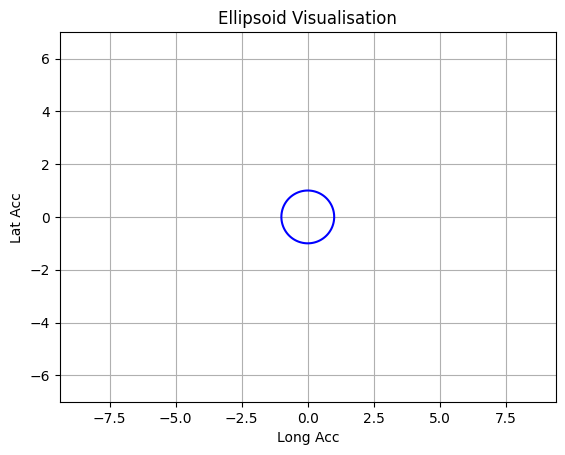

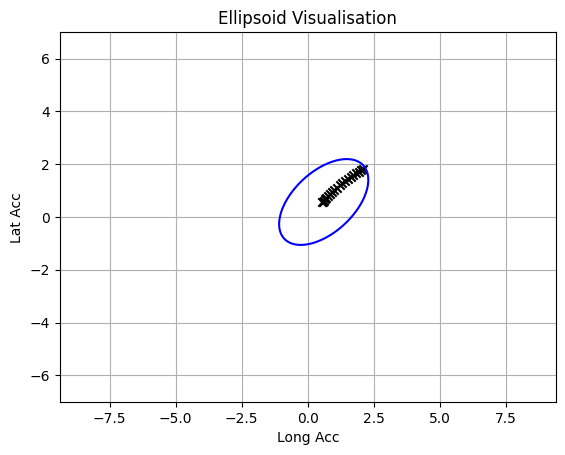

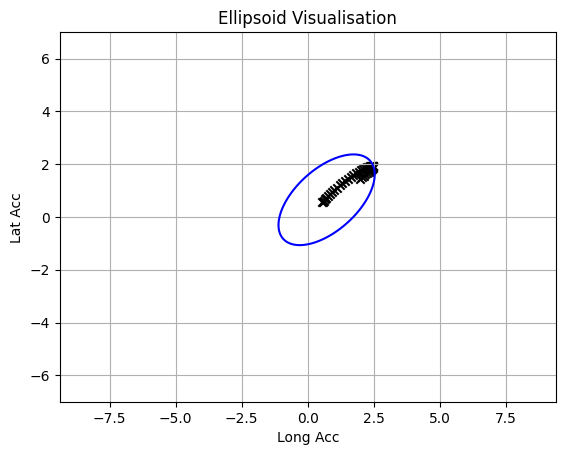

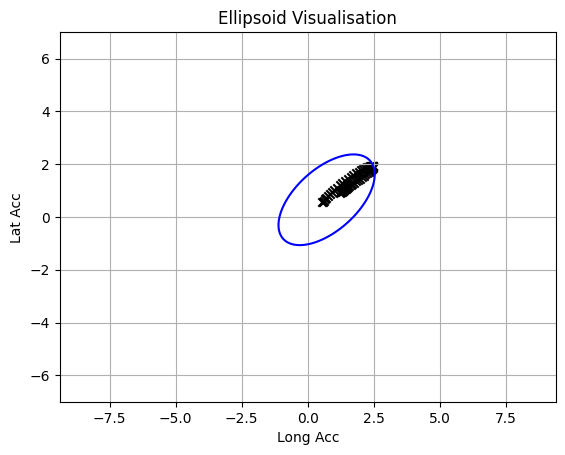

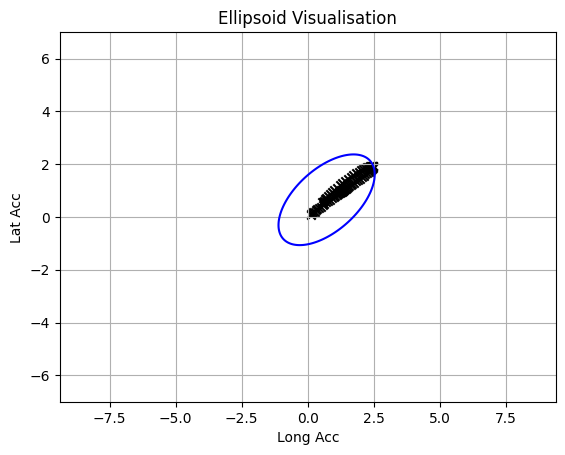

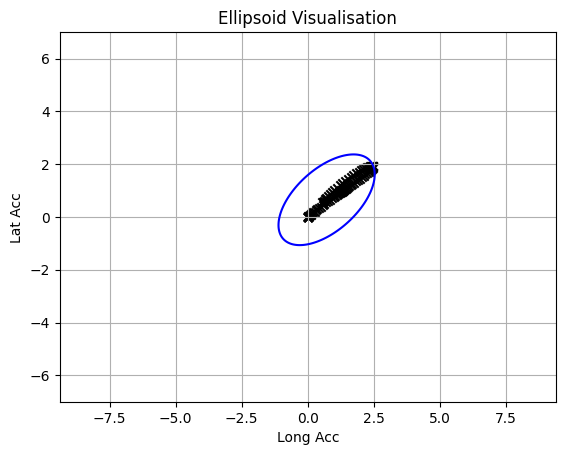

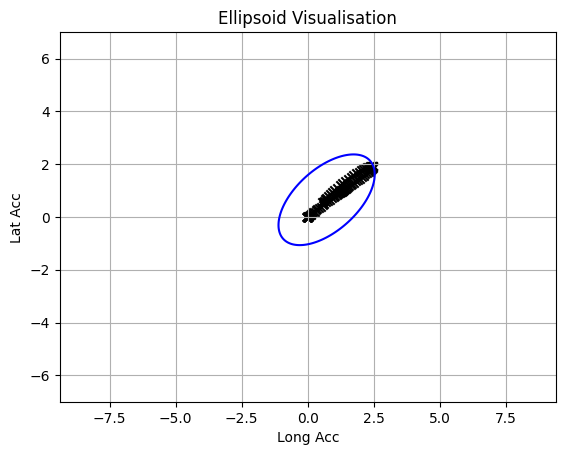

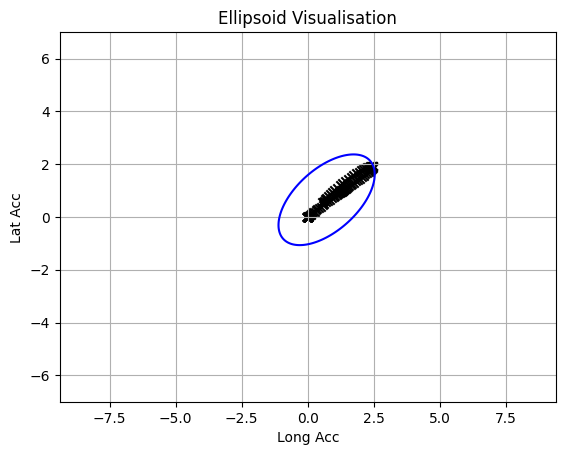

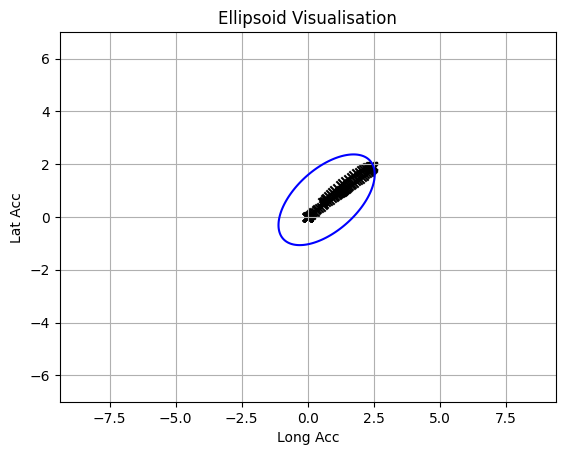

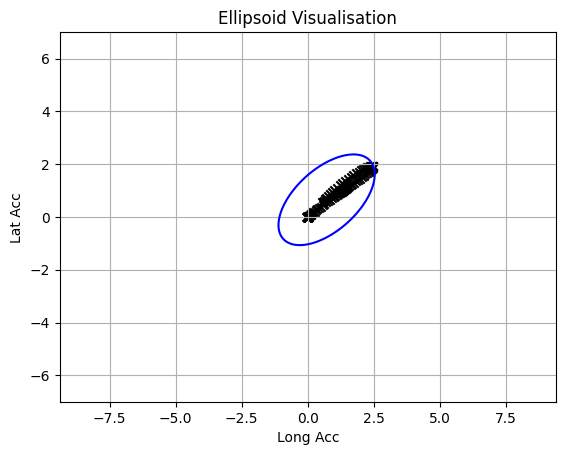

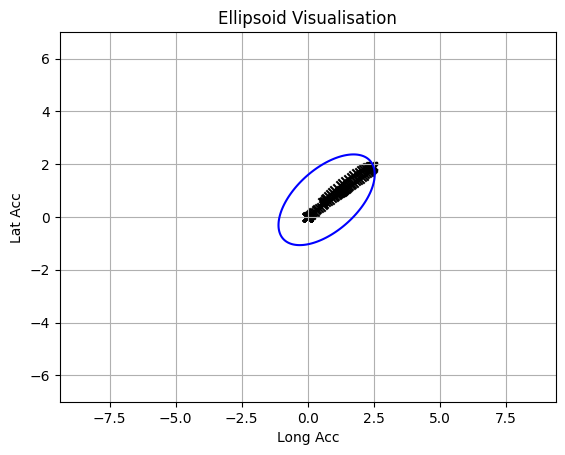

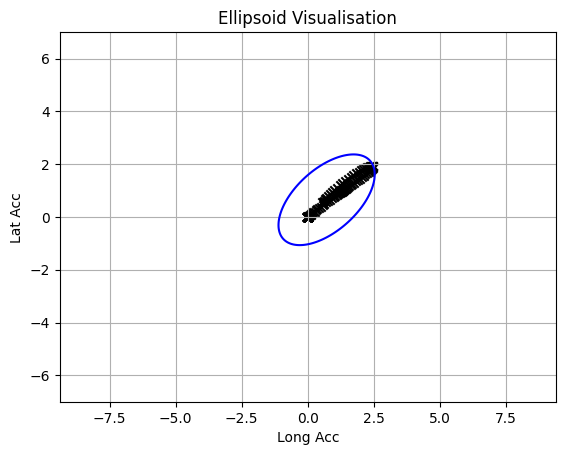

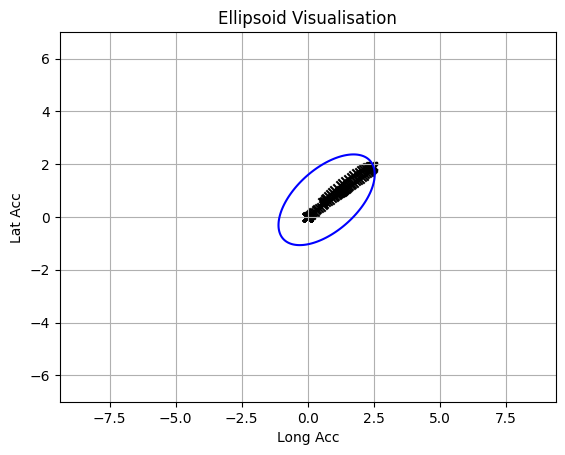

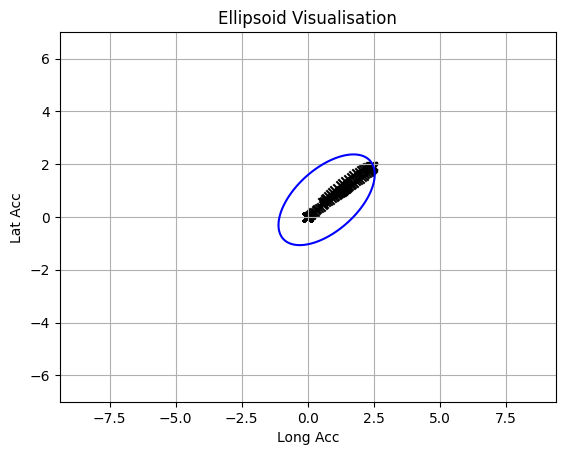

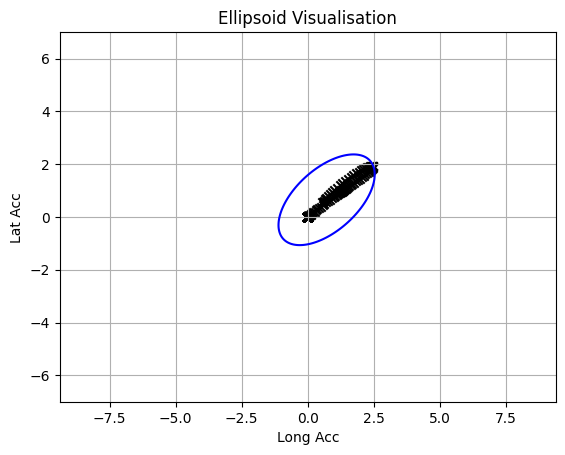

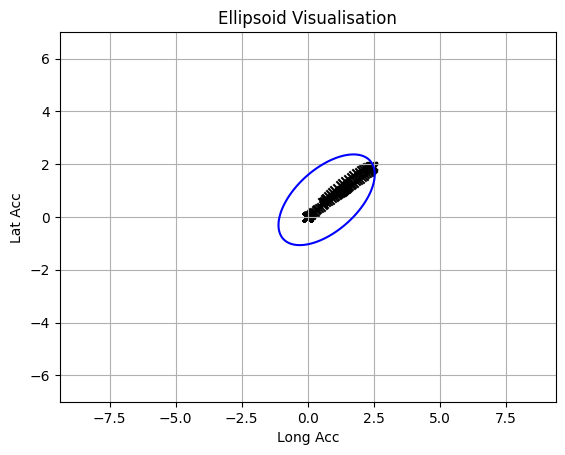

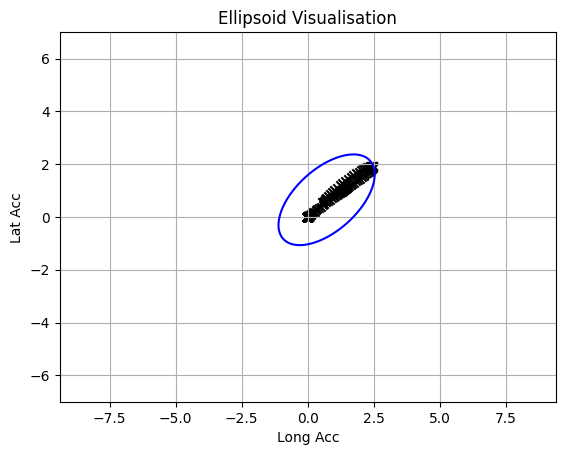

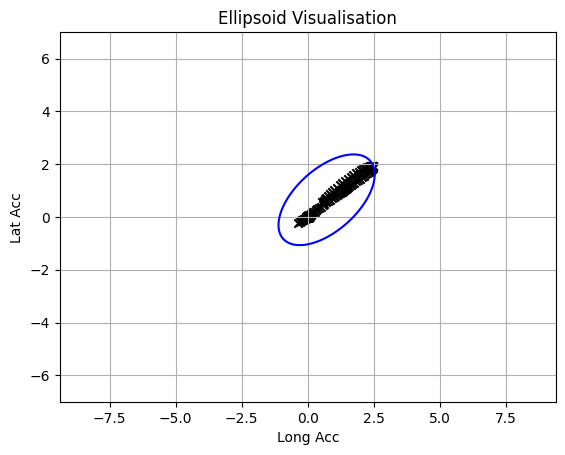

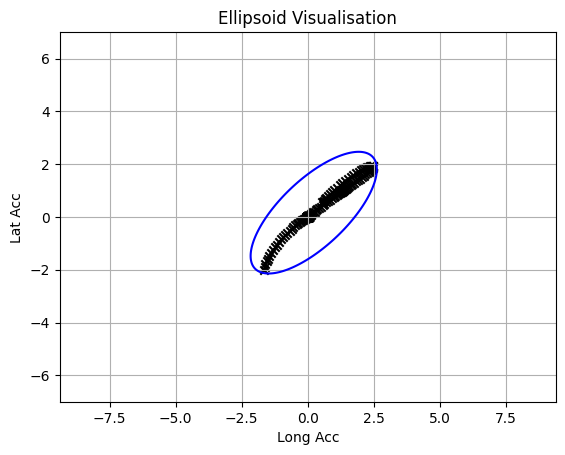

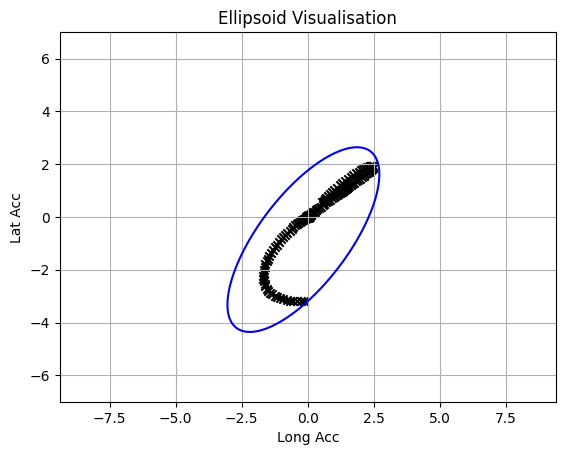

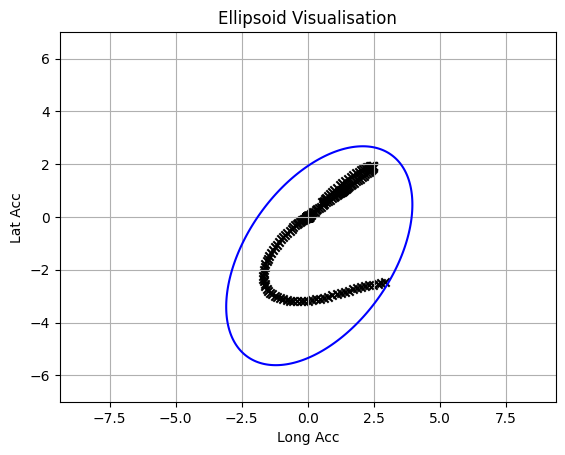

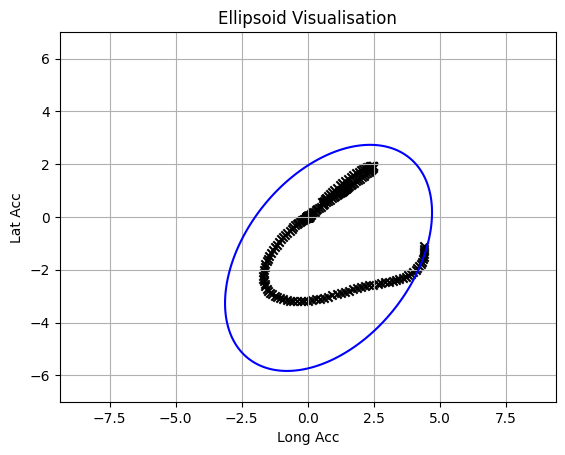

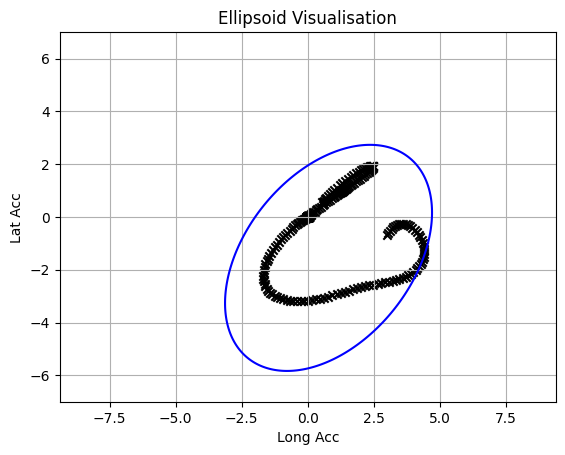

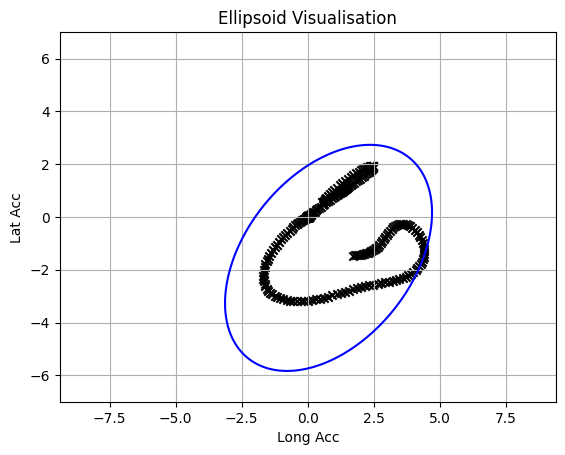

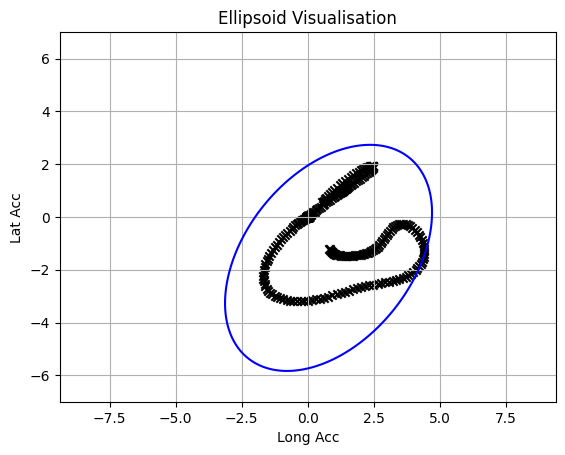

In [813]:
u_init = np.array([[random_vals[0,0]],[random_vals[1,0]]])
B_pre, b_tilde_pre = opti_SDP_lemma(nu,A_init,b_init,c_init,u_init)
A_pre = sqrtm(B_pre)
b_pre = np.linalg.inv(A_pre)@b_tilde_pre

for i in range(N_Sam):
    A_last = A_pre.T@A_pre
    b_last = A_pre.T@b_pre
    c_last = b_pre.T@b_pre-1
    u_last = np.array([[random_vals[0,i]],[random_vals[1,i]]])
    B_pre, b_tilde_pre = opti_SDP_lemma(nu,A_last,b_last,c_last,u_last)
    A_pre = sqrtm(B_pre)
    b_pre = np.linalg.inv(A_pre)@b_tilde_pre
    if i % 20 == 0:
        plot_el(A_pre,b_pre,i)